## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-06 10:15:32.825740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 10:15:32.825774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-06 10:16:00.624759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-06 10:16:00.624825: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 10:16:00.624882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall12): /proc/driver/nvidia/version does not exist
2022-05-06 10:16:00.628015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 14s 39ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building a preprocessing routine

In [6]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Resnet8 Student model 

In [7]:
print("============== Building Student Network Resnet8 ! =============")

student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

student = tf.keras.Sequential([
    preprocessing,
    student,   
])



student_scratch = tf.keras.models.clone_model(student)

print("")

============== Building Student Network Resnet8 ! =============



## Building callbacks

In [8]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [9]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 105s 65ms/step - sparse_categorical_accuracy: 0.4569 - student_loss: 2.0946 - loss: 1.2131 - val_sparse_categorical_accuracy: 0.4717 - val_student_loss: 2.6400 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 98s 63ms/step - sparse_categorical_accuracy: 0.6227 - student_loss: 1.7494 - loss: 0.8685 - val_sparse_categorical_accuracy: 0.5996 - val_student_loss: 2.4348 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 97s 62ms/step - sparse_categorical_accuracy: 0.6764 - student_loss: 1.5335 - loss: 0.7380 - val_sparse_categorical_accuracy: 0.6163 - val_student_loss: 1.4725 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 92s 59ms/step - sparse_categorical_accuracy: 0.7121 - student_loss: 1.3828 - loss: 0.6522 - val_sparse_categorical_accuracy: 0.6668 - val_student_loss: 1.4037 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 75s 48ms/step - sparse_cat

Epoch 36/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9433 - student_loss: 0.2087 - loss: 0.1616 - val_sparse_categorical_accuracy: 0.8533 - val_student_loss: 1.2773 - lr: 0.0100
Epoch 37/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9436 - student_loss: 0.2048 - loss: 0.1606 - val_sparse_categorical_accuracy: 0.8516 - val_student_loss: 1.2773 - lr: 0.0100
Epoch 38/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9464 - student_loss: 0.1923 - loss: 0.1578 - val_sparse_categorical_accuracy: 0.8520 - val_student_loss: 1.3199 - lr: 0.0100
Epoch 39/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9474 - student_loss: 0.1915 - loss: 0.1565 - val_sparse_categorical_accuracy: 0.8516 - val_student_loss: 1.3302 - lr: 0.0100
Epoch 40/100
1562/1562 [==============================] - 74s 47ms/step - sparse

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9533 - student_loss: 0.1625 - loss: 0.1470 - val_sparse_categorical_accuracy: 0.8511 - val_student_loss: 1.3031 - lr: 1.0000e-05
Epoch 69/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9537 - student_loss: 0.1612 - loss: 0.1464 - val_sparse_categorical_accuracy: 0.8521 - val_student_loss: 1.3048 - lr: 1.0000e-05
Epoch 70/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9529 - student_loss: 0.1610 - loss: 0.1469 - val_sparse_categorical_accuracy: 0.8528 - val_student_loss: 1.3034 - lr: 1.0000e-05
Epoch 71/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9527 - student_loss: 0.1625 - loss: 0.1476 - val_sparse_categorical_accuracy: 0.8519 - val_student_loss: 1.3039 - lr: 1.0000e-05
Epoch 72/100
1562/1562 [============================>.] - ETA: 0s - sparse_ca

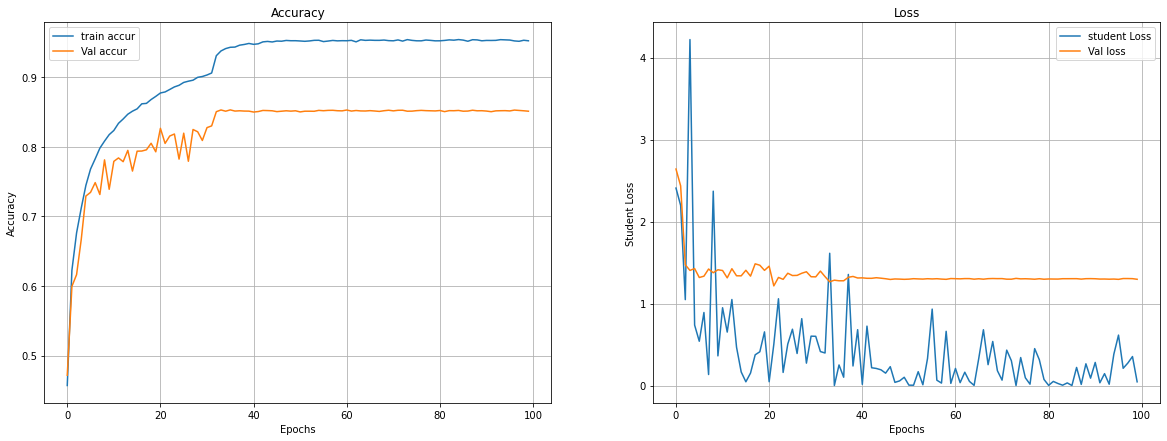

Saving model 


2022-05-06 12:18:17.582903: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 76s 47ms/step - sparse_categorical_accuracy: 0.4718 - student_loss: 1.7780 - loss: 1.2654 - val_sparse_categorical_accuracy: 0.4530 - val_student_loss: 2.5695 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.6248 - student_loss: 1.4673 - loss: 0.9376 - val_sparse_categorical_accuracy: 0.6034 - val_student_loss: 2.5970 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6814 - student_loss: 1.3095 - loss: 0.8048 - val_sparse_categorical_accuracy: 0.5389 - val_student_loss: 1.4713 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7196 - student_loss: 1.1869 - loss: 0.7102 - val_sparse_categorical_accuracy: 0.6610 - 

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9329 - student_loss: 0.2400 - loss: 0.1923 - val_sparse_categorical_accuracy: 0.8485 - val_student_loss: 1.3782 - lr: 0.0100
Epoch 36/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9326 - student_loss: 0.2355 - loss: 0.1910 - val_sparse_categorical_accuracy: 0.8497 - val_student_loss: 1.3784 - lr: 0.0100
Epoch 37/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9339 - student_loss: 0.2322 - loss: 0.1892
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9339 - student_loss: 0.2320 - loss: 0.1892 - val_sparse_categorical_accuracy: 0.8472 - val_student_loss: 1.3812 - lr: 0.0100
Epoch 38/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9384 - stude

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9396 - student_loss: 0.2073 - loss: 0.1795
Epoch 67: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9396 - student_loss: 0.2076 - loss: 0.1796 - val_sparse_categorical_accuracy: 0.8497 - val_student_loss: 1.3884 - lr: 1.0000e-05
Epoch 68/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9397 - student_loss: 0.2082 - loss: 0.1794 - val_sparse_categorical_accuracy: 0.8493 - val_student_loss: 1.3879 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.9401 - student_loss: 0.2081 - loss: 0.1792 - val_sparse_categorical_accuracy: 0.8494 - val_student_loss: 1.3878 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9402 - student_l

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8490 - student_loss: 1.5391

 =============== History Plot ===============


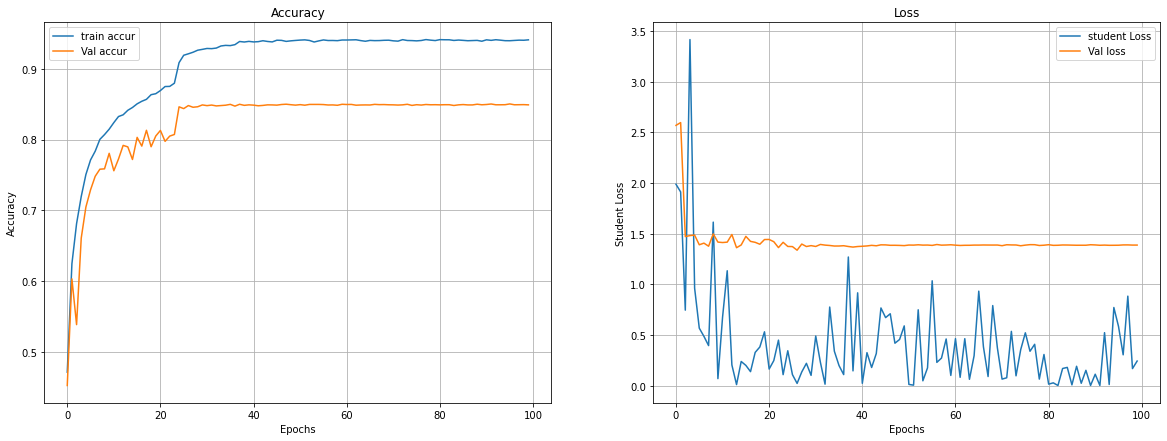

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 48ms/step - sparse_categorical_accuracy: 0.4605 - student_loss: 1.6305 - loss: 1.3345 - val_sparse_categorical_accuracy: 0.4377 - val_student_loss: 2.5449 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6168 - student_loss: 1.3182 - loss: 1.0100 - val_sparse_categorical_accuracy: 0.5409 - val_student_loss: 2.6273 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6735 - student_loss: 1.1854 - loss: 0.8801 - val_sparse_categorical_accuracy: 0.5659 - val_student_loss: 2.5008 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.7087 - student_loss: 1.0857 - loss: 0.7898 - val_sparse_categorical_accur

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9293 - student_loss: 0.2421 - loss: 0.2099
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9292 - student_loss: 0.2428 - loss: 0.2103 - val_sparse_categorical_accuracy: 0.8460 - val_student_loss: 1.3838 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9333 - student_loss: 0.2224 - loss: 0.2005 - val_sparse_categorical_accuracy: 0.8470 - val_student_loss: 1.3946 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9338 - student_loss: 0.2220 - loss: 0.2001 - val_sparse_categorical_accuracy: 0.8475 - val_student_loss: 1.3987 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9351

Epoch 66/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9372 - student_loss: 0.2116 - loss: 0.1952 - val_sparse_categorical_accuracy: 0.8468 - val_student_loss: 1.3909 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9357 - student_loss: 0.2144 - loss: 0.1965 - val_sparse_categorical_accuracy: 0.8476 - val_student_loss: 1.3974 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9349 - student_loss: 0.2193 - loss: 0.1985 - val_sparse_categorical_accuracy: 0.8462 - val_student_loss: 1.3951 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9355 - student_loss: 0.2119 - loss: 0.1956 - val_sparse_categorical_accuracy: 0.8470 - val_student_loss: 1.3959 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 72s 46

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8480 - student_loss: 1.5514

 =============== History Plot ===============


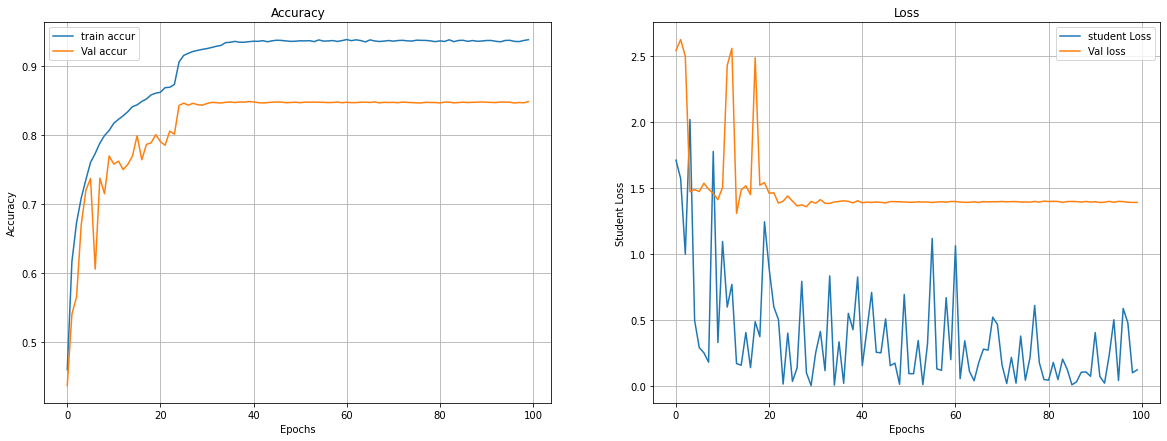

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 49ms/step - sparse_categorical_accuracy: 0.4607 - student_loss: 1.5633 - loss: 1.3863 - val_sparse_categorical_accuracy: 0.3210 - val_student_loss: 5.4632 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6148 - student_loss: 1.2183 - loss: 1.0501 - val_sparse_categorical_accuracy: 0.5428 - val_student_loss: 2.6315 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6778 - student_loss: 1.0759 - loss: 0.9108 - val_sparse_categorical_accuracy: 0.6698 - val_student_loss: 1.4428 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.7158 - student_loss: 0.9748 - loss: 0.8121 - val_sparse_categorical_accur

1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9245 - student_loss: 0.2448 - loss: 0.2291 - val_sparse_categorical_accuracy: 0.8388 - val_student_loss: 1.3677 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9247 - student_loss: 0.2446 - loss: 0.2283 - val_sparse_categorical_accuracy: 0.8386 - val_student_loss: 1.3485 - lr: 0.0100
Epoch 36/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9262 - student_loss: 0.2388 - loss: 0.2247 - val_sparse_categorical_accuracy: 0.8374 - val_student_loss: 1.3336 - lr: 0.0100
Epoch 37/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9279 - student_loss: 0.2368 - loss: 0.2230
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9279 - stude

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9342 - student_loss: 0.2120 - loss: 0.2082 - val_sparse_categorical_accuracy: 0.8376 - val_student_loss: 1.3258 - lr: 1.0000e-05
Epoch 67/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9350 - student_loss: 0.2090 - loss: 0.2068
Epoch 67: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9350 - student_loss: 0.2088 - loss: 0.2067 - val_sparse_categorical_accuracy: 0.8386 - val_student_loss: 1.3270 - lr: 1.0000e-05
Epoch 68/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9340 - student_loss: 0.2106 - loss: 0.2075 - val_sparse_categorical_accuracy: 0.8386 - val_student_loss: 1.3238 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9340 - student_l

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8378 - student_loss: 1.5242

 =============== History Plot ===============


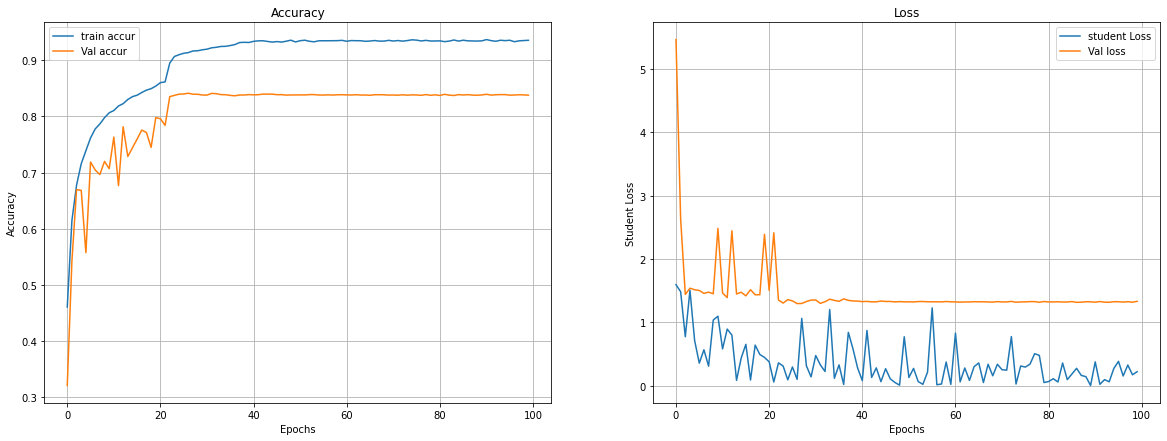

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4579 - student_loss: 1.5177 - loss: 1.4169 - val_sparse_categorical_accuracy: 0.4585 - val_student_loss: 2.5454 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6215 - student_loss: 1.1453 - loss: 1.0707 - val_sparse_categorical_accuracy: 0.6005 - val_student_loss: 2.5022 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.6774 - student_loss: 1.0067 - loss: 0.9313 - val_sparse_categorical_accuracy: 0.6218 - val_student_loss: 1.4950 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.7125 - student_loss: 0.9114 - loss: 0.8363 - val_sparse_categorical_accur

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9270 - student_loss: 0.2318 - loss: 0.2316 - val_sparse_categorical_accuracy: 0.8418 - val_student_loss: 1.4218 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9265 - student_loss: 0.2247 - loss: 0.2264 - val_sparse_categorical_accuracy: 0.8432 - val_student_loss: 1.4290 - lr: 0.0100
Epoch 36/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9272 - student_loss: 0.2217 - loss: 0.2241 - val_sparse_categorical_accuracy: 0.8436 - val_student_loss: 1.4499 - lr: 0.0100
Epoch 37/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9285 - student_loss: 0.2205 - loss: 0.2229 - val_sparse_categorical_accuracy: 0.8415 - val_student_loss: 1.3913 - lr: 0.0100
Epoch 38/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_

Epoch 68/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9515 - student_loss: 0.1426 - loss: 0.1680 - val_sparse_categorical_accuracy: 0.8427 - val_student_loss: 1.3979 - lr: 1.0000e-04
Epoch 69/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9519 - student_loss: 0.1397 - loss: 0.1663 - val_sparse_categorical_accuracy: 0.8418 - val_student_loss: 1.3983 - lr: 1.0000e-04
Epoch 70/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9524 - student_loss: 0.1388 - loss: 0.1656 - val_sparse_categorical_accuracy: 0.8422 - val_student_loss: 1.3983 - lr: 1.0000e-04
Epoch 71/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9514 - student_loss: 0.1422 - loss: 0.1680 - val_sparse_categorical_accuracy: 0.8416 - val_student_loss: 1.3992 - lr: 1.0000e-04
Epoch 72/100
1562/1562 [==============================] - 74s 48

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8420 - student_loss: 1.5441

 =============== History Plot ===============


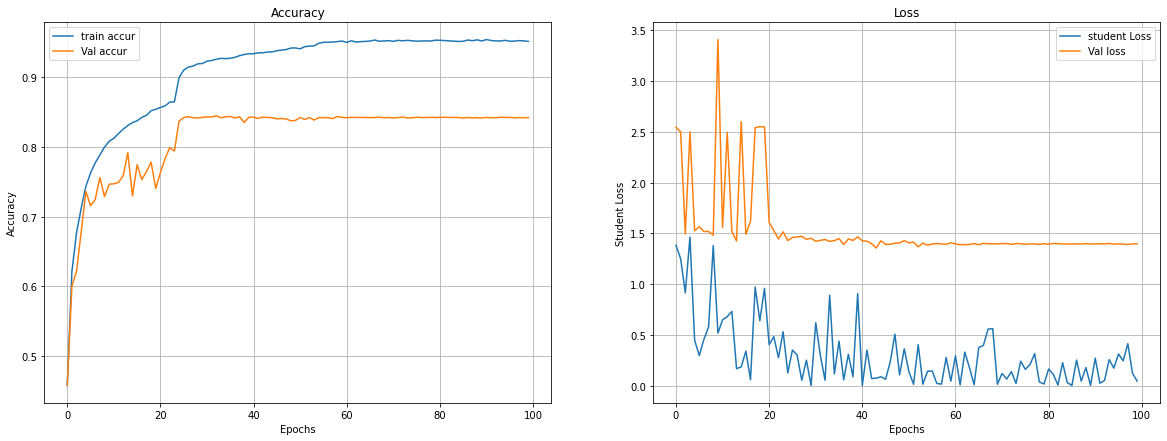

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 78s 48ms/step - sparse_categorical_accuracy: 0.4485 - student_loss: 1.5164 - loss: 1.4568 - val_sparse_categorical_accuracy: 0.4851 - val_student_loss: 3.5059 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6131 - student_loss: 1.1283 - loss: 1.1067 - val_sparse_categorical_accuracy: 0.5559 - val_student_loss: 2.5449 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6774 - student_loss: 0.9658 - loss: 0.9489 - val_sparse_categorical_accuracy: 0.4644 - val_student_loss: 2.5697 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.7136 - student_loss: 0.8677 - loss: 0.8499 - val_sparse_categorical_accur

1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9092 - student_loss: 0.2746 - loss: 0.2832 - val_sparse_categorical_accuracy: 0.8392 - val_student_loss: 1.3880 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9096 - student_loss: 0.2773 - loss: 0.2848 - val_sparse_categorical_accuracy: 0.8389 - val_student_loss: 1.3855 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9098 - student_loss: 0.2701 - loss: 0.2799 - val_sparse_categorical_accuracy: 0.8377 - val_student_loss: 1.3804 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9109 - student_loss: 0.2718 - loss: 0.2805
Epoch 36: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9101 - student_loss: 0.2717 - loss: 0.2803 - val_sparse_categorical_accuracy: 0.8384 - val_student_loss: 1.4023 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9109 - student_loss: 0.2700 - loss: 0.2794 - val_sparse_categorical_accuracy: 0.8381 - val_student_loss: 1.3945 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9121 - student_loss: 0.2684 - loss: 0.2783 - val_sparse_categorical_accuracy: 0.8378 - val_student_loss: 1.3937 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9107 - student_loss: 0.2723 - loss: 0.2807 - val_sparse_categorical_accuracy: 0.8384 - val_student_loss: 1.3948 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 75s 48ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8382 - student_loss: 1.5442

 =============== History Plot ===============


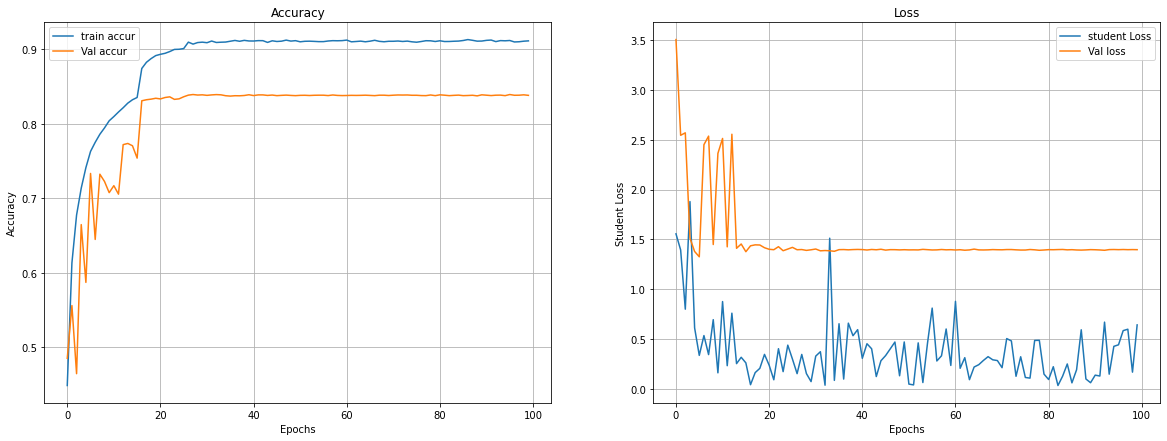

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 76s 46ms/step - sparse_categorical_accuracy: 0.4769 - student_loss: 1.4321 - loss: 1.4078 - val_sparse_categorical_accuracy: 0.4307 - val_student_loss: 2.4988 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6297 - student_loss: 1.0581 - loss: 1.0660 - val_sparse_categorical_accuracy: 0.5687 - val_student_loss: 2.5580 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6877 - student_loss: 0.9160 - loss: 0.9289 - val_sparse_categorical_accuracy: 0.6433 - val_student_loss: 2.4643 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.7230 - student_loss: 0.8170 - loss: 0.8310 - val_sparse_categorical_accur

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9221 - student_loss: 0.2258 - loss: 0.2475 - val_sparse_categorical_accuracy: 0.8415 - val_student_loss: 1.4014 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.9233 - student_loss: 0.2233 - loss: 0.2452 - val_sparse_categorical_accuracy: 0.8422 - val_student_loss: 1.4045 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9217 - student_loss: 0.2292 - loss: 0.2494 - val_sparse_categorical_accuracy: 0.8407 - val_student_loss: 1.4101 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9234 - student_loss: 0.2253 - loss: 0.2463 - val_sparse_categorical_accuracy: 0.8418 - val_student_loss: 1.4071 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 74s 47ms/step - spa

1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9242 - student_loss: 0.2241 - loss: 0.2449 - val_sparse_categorical_accuracy: 0.8418 - val_student_loss: 1.3951 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9232 - student_loss: 0.2237 - loss: 0.2446 - val_sparse_categorical_accuracy: 0.8430 - val_student_loss: 1.4034 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9238 - student_loss: 0.2240 - loss: 0.2449 - val_sparse_categorical_accuracy: 0.8425 - val_student_loss: 1.3992 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9245 - student_loss: 0.2215 - loss: 0.2427 - val_sparse_categorical_accuracy: 0.8418 - val_student_loss: 1.3982 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 75s 48ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8430 - student_loss: 1.5505

 =============== History Plot ===============


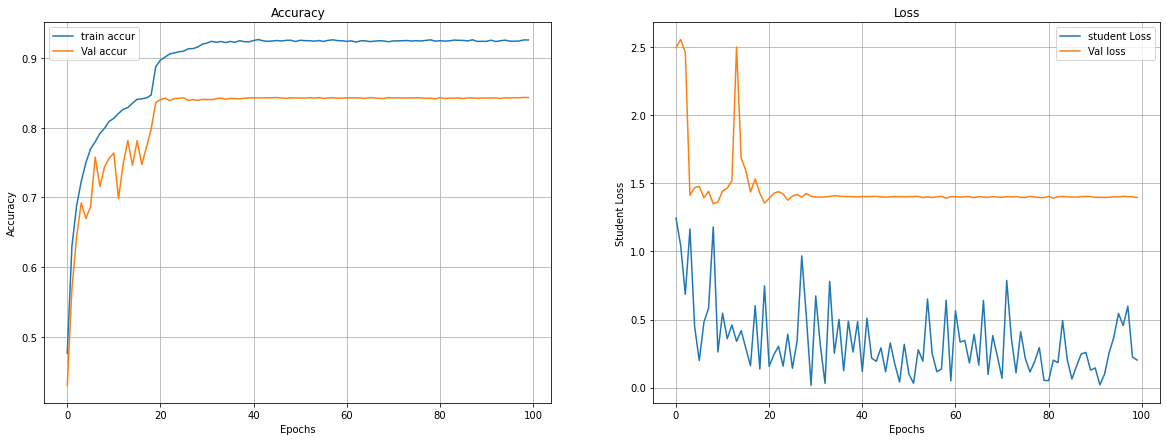

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 80s 49ms/step - sparse_categorical_accuracy: 0.4630 - student_loss: 1.4627 - loss: 1.4498 - val_sparse_categorical_accuracy: 0.4589 - val_student_loss: 3.4051 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6218 - student_loss: 1.0700 - loss: 1.0871 - val_sparse_categorical_accuracy: 0.5827 - val_student_loss: 2.5010 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6767 - student_loss: 0.9224 - loss: 0.9453 - val_sparse_categorical_accuracy: 0.5594 - val_student_loss: 2.4087 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.7162 - student_loss: 0.8177 - loss: 0.8439 - val_sparse_categorical_accur

1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9224 - student_loss: 0.2235 - loss: 0.2480 - val_sparse_categorical_accuracy: 0.8390 - val_student_loss: 1.4241 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9232 - student_loss: 0.2226 - loss: 0.2470 - val_sparse_categorical_accuracy: 0.8388 - val_student_loss: 1.4225 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9228 - student_loss: 0.2214 - loss: 0.2454 - val_sparse_categorical_accuracy: 0.8397 - val_student_loss: 1.4205 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9241 - student_loss: 0.2222 - loss: 0.2459 - val_sparse_categorical_accuracy: 0.8402 - val_student_loss: 1.4191 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 74s 47ms/step - spa

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9244 - student_loss: 0.2190 - loss: 0.2424 - val_sparse_categorical_accuracy: 0.8396 - val_student_loss: 1.4167 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9251 - student_loss: 0.2149 - loss: 0.2392 - val_sparse_categorical_accuracy: 0.8401 - val_student_loss: 1.4181 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9259 - student_loss: 0.2141 - loss: 0.2384 - val_sparse_categorical_accuracy: 0.8393 - val_student_loss: 1.4162 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9248 - student_loss: 0.2160 - loss: 0.2401 - val_sparse_categorical_accuracy: 0.8392 - val_student_loss: 1.4170 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 75s 48ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8408 - student_loss: 1.5356

 =============== History Plot ===============


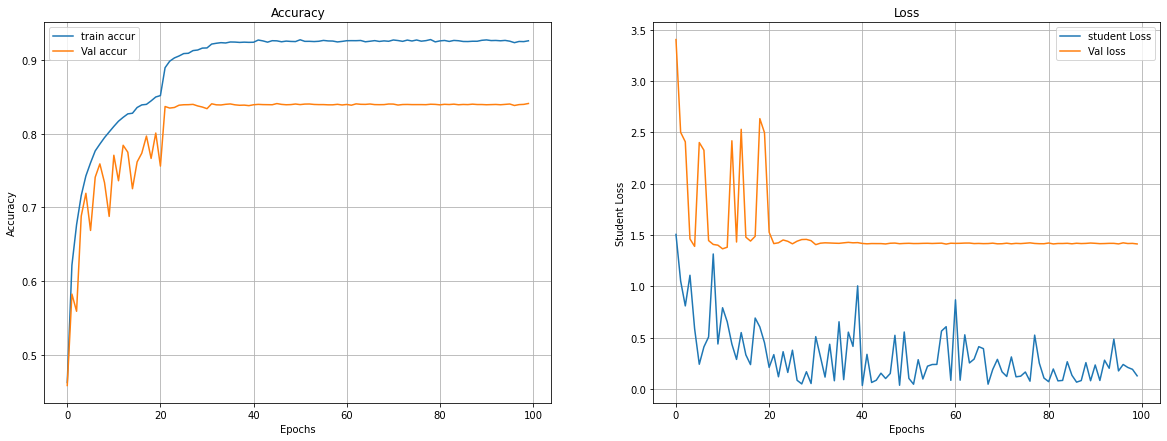

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 78s 47ms/step - sparse_categorical_accuracy: 0.4641 - student_loss: 1.4573 - loss: 1.4535 - val_sparse_categorical_accuracy: 0.4025 - val_student_loss: 2.4974 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.6237 - student_loss: 1.0539 - loss: 1.0672 - val_sparse_categorical_accuracy: 0.6332 - val_student_loss: 2.5300 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6867 - student_loss: 0.8916 - loss: 0.9096 - val_sparse_categorical_accuracy: 0.6176 - val_student_loss: 2.4429 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.7235 - student_loss: 0.7916 - loss: 0.8113 - val_sparse_categorical_accur

1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9085 - student_loss: 0.2645 - loss: 0.2848 - val_sparse_categorical_accuracy: 0.8336 - val_student_loss: 1.4621 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9098 - student_loss: 0.2622 - loss: 0.2825 - val_sparse_categorical_accuracy: 0.8326 - val_student_loss: 1.4714 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9087 - student_loss: 0.2620 - loss: 0.2822
Epoch 35: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9087 - student_loss: 0.2617 - loss: 0.2820 - val_sparse_categorical_accuracy: 0.8326 - val_student_loss: 1.4570 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9095 - student_loss: 0.2633 - loss: 0.2832 - val_sparse_categorical_accuracy: 0.8320 - val_student_loss: 1.4592 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9095 - student_loss: 0.2603 - loss: 0.2804 - val_sparse_categorical_accuracy: 0.8329 - val_student_loss: 1.4631 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9107 - student_loss: 0.2588 - loss: 0.2791 - val_sparse_categorical_accuracy: 0.8329 - val_student_loss: 1.4590 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9098 - student_loss: 0.2616 - loss: 0.2816 - val_sparse_categorical_accuracy: 0.8320 - val_student_loss: 1.4569 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 73s 47ms/step - spa

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.8320 - student_loss: 1.5693

 =============== History Plot ===============


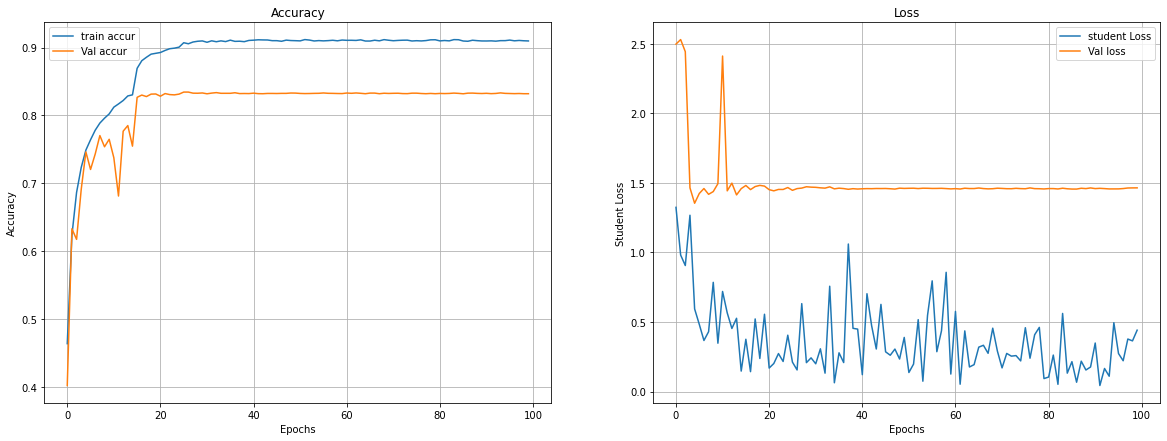

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [10]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_{a}_temp_{5}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)
    student = tf.keras.Sequential([
        preprocessing,
        student,   
    ])

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_alpha{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_alpha{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_alpha_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")